Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('digits.csv')

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Data Preprocessing</h1>

Train and test Splitting

In [4]:

def one_hot(labels, num_classes=10):
    
    return np.eye(num_classes)[labels]

In [5]:
def prepare_train_data():
    
    
    
    training_data = data.loc[0:40000]
    X_train = training_data.drop(columns = "label")
    X_train = X_train / 255
    y_train_label = training_data["label"]

    
    X_train = np.array(X_train)
    m,n = X_train.shape
    y_train = np.array(y_train_label)
    y_train = one_hot(y_train)
    

    return X_train,y_train,y_train_label


In [6]:
X_train,y_train,y_train_lbel = prepare_train_data()

In [7]:
X_train.shape

(40001, 784)

In [8]:
y_train.shape

(40001, 10)

In [9]:
def prepare_test_data():
    
    testing_data = data.loc[40000:42000]
    X_test = testing_data.drop(columns="label")
    X_test = X_test / 255
    y_test_label = testing_data["label"]

    
    X_test = np.array(X_test)
    y_test = np.array(y_test_label)

    y_test = one_hot(y_test)

    return X_test,y_test,y_test_label

<h1> Neural Network Architecture </h1>

Layers, nodes, weights and biases.

In [10]:
def init_params():
    # nodes per layer
    n = [784,10,10]

    w1 = np.random.randn(n[1],n[0]) * np.sqrt(2. / n[0])
    
    w2 = np.random.randn(n[2],n[1]) *  np.sqrt(2. / n[1])
    
    
    b1 = np.random.randn(n[1],1)
    
    b2 = np.random.randn(n[2],1)

    return w1,b1,w2,b2


Activation functions

In [11]:
def relu(z):
    return np.maximum(z,0)

def d_relu(z):
    return (z > 0).astype(np.float32)

In [12]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def d_soft(A2, y_train):
    
    return A2 - y_train 


Cross Entropy Loss Function for Multiple Classes

In [13]:
def categorical_crossentropy_loss(y_train, y_hat):
    
    y_hat = np.clip(y_hat, 1e-10, 1 - 1e-10)
    m = y_train.shape[0]
    
    loss = -np.sum(y_train.T * np.log(y_hat))/m
    
    return loss

Forward Propagation

In [14]:
def forward_prop(X_train,w1,b1,w2,b2):
    
    A0 = X_train.T
    

    z1 =  np.dot(w1,A0) + b1
    A1 = relu(z1)

    
    z2 = np.dot(w2,A1) + b2

    A2 = softmax(z2)
    cache = {"A0" :A0,
             "A1" : A1,
             "A2" : A2 ,
             "z2" : z2,
             "z1" : z1}
    
    return cache


Back Propagation

In [15]:
def back_prop(X_train,y_train,cache,w1,b1,w2,b2,alpha=0.01,m=X_train.shape[0]):
    
    
    A0 = cache["A0"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    z1 = cache["z1"]
    z2 = cache["z2"]

    
    da2 = d_soft(A2,y_train.T)
    dz2 = da2

    dw2 = np.dot(dz2,A1.T)/m
    db2 = np.sum(dz2,axis=1,keepdims=True)/m


    da1 = np.dot(w2.T,dz2)
    dz1 = da1 * d_relu(z1)

    dw1 = np.dot(dz1,A0.T)/m
    db1 = np.sum(dz1,axis=1,keepdims = True)/m

    
    
    w1 -= alpha * dw1  
    b1 -= alpha * db1  
    w2 -= alpha * dw2  
    b2 -= alpha * db2  
    

    
    gradients = {
        "dW1": dw1,
        "db1": db1,
        "dW2": dw2,
        "db2": db2
    }

    return w1, b1, w2, b2, gradients




The training function

In [16]:
def train(X_train, y_train, num_epochs=1500, alpha=0.15, hidden_size=10, output_size=10):
    
    
    input_size = X_train.shape[0]  
    m = X_train.shape[1] 

    
    w1, b1, w2, b2 = init_params()
    losses =[]
    
    for epoch in range(num_epochs):
        
        cache = forward_prop(X_train, w1, b1, w2, b2)

        
        A2 = cache["A2"]

        
        loss = categorical_crossentropy_loss(y_train, A2)
        losses.append(loss)

        
        w1, b1, w2, b2, gradients = back_prop(X_train, y_train, cache, w1, b1, w2, b2, alpha)

        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}")
            

    model = {"w1" : w1,
               "w2" : w2,
               "b1" : b1,
               "b2" : b2}
    
    return model,losses


A script that builds the model.

In [18]:
X_train,y_train,y_train_label = prepare_train_data()

model_cache,errors = train(X_train,y_train)

Epoch 0/1500, Loss: 2.7314
Epoch 100/1500, Loss: 0.5662
Epoch 200/1500, Loss: 0.4027
Epoch 300/1500, Loss: 0.3545
Epoch 400/1500, Loss: 0.3302
Epoch 500/1500, Loss: 0.3150
Epoch 600/1500, Loss: 0.3043
Epoch 700/1500, Loss: 0.2961
Epoch 800/1500, Loss: 0.2895
Epoch 900/1500, Loss: 0.2839
Epoch 1000/1500, Loss: 0.2791
Epoch 1100/1500, Loss: 0.2750
Epoch 1200/1500, Loss: 0.2714
Epoch 1300/1500, Loss: 0.2681
Epoch 1400/1500, Loss: 0.2651


In [18]:
model_cache.keys()

dict_keys(['w1', 'w2', 'b1', 'b2'])

In [19]:
def model_predict(X, model_cache):
    

    w1 = model_cache["w1"]
    b1 = model_cache["b1"]
    w2 = model_cache["w2"]
    b2 = model_cache["b2"]
    
    
    A0 = X.T
    z1 = np.dot(w1, A0) + b1  
    A1 = relu(z1)  
    
    z2 = np.dot(w2, A1) + b2  
    A2 = softmax(z2)  

    
    predictions = np.argmax(A2, axis=0)
    
    return predictions

In [20]:
def image_predict(image,model_cache):

    
    w1 = model_cache["w1"]
    b1 = model_cache["b1"]
    w2 = model_cache["w2"]
    b2 = model_cache["b2"]

    
    image = image.reshape(1,-1)

    
    A0 = image.T  
    z1 = np.dot(w1, A0) + b1 
    A1 = relu(z1)  
    
    z2 = np.dot(w2, A1) + b2  
    A2 = softmax(z2)  

    
    image_prediction = np.argmax(A2, axis=0)  
    
    return image_prediction[0]


<h1> Model Perfomance </h1>

In [21]:
def performance_metrics(X_test,y_test,y_test_label):
    
    y_pred = model_predict(X_test,model_cache)
    y_pred = pd.DataFrame(y_pred)
    y_pred.rename(columns = {0 : "prediction"},inplace=True)

    y_actual = pd.DataFrame(y_test_label)
    y_actual.rename(columns = {"label" : "actual"},inplace=True)
    y_actual.reset_index(drop=True,inplace=True)

    compare_df = pd.concat([y_pred,y_actual],axis=1)
    compare_df["correct"] = compare_df["prediction"] == compare_df["actual"]

    amount_correct = compare_df["correct"].sum(axis=0)
    accuracy = amount_correct/len(compare_df)

    return compare_df,accuracy
    

In [22]:
X_test,y_test,y_test_label = prepare_test_data()

compare_df,accuracy = performance_metrics(X_test,y_test,y_test_label)

In [23]:
print("accuracy:",accuracy)

accuracy: 0.9085


In [27]:
compare_df

,Prediction,Actual,Correct
0,2,2,True
1,3,3,True
2,3,9,False
3,7,7,True
4,8,8,True
...,...,...,...
1995,0,0,True
1996,1,1,True
1997,7,7,True
1998,6,6,True


Plotting the Cost

In [73]:
def plot_cost(error_list,iterations=range(1,1501)):
    plt.plot(iterations,errors)
    plt.xlabel('Epochs')
    plt.ylabel("Cost")
    plt.title("Cost over Epochs")
    plt.show()

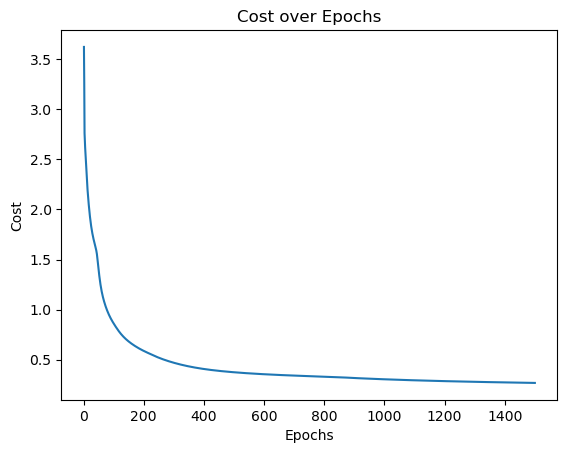

In [74]:
plot_cost(errors)

<h1> Model Serialization </h1>

In [75]:
import pickle

Inside the pickle I want the model, the feed forward function, and accuracy metrics.

In [81]:
model_cache

{'w1': array([[-0.01839759,  0.06275458, -0.00862762, ..., -0.05178352,
          0.07739124,  0.0414599 ],
        [-0.04272554, -0.04273976, -0.00311958, ..., -0.04812657,
          0.04625804, -0.07375862],
        [-0.01288278, -0.02646478, -0.03240016, ..., -0.02753372,
          0.03503061,  0.02987456],
        ...,
        [-0.05597791, -0.03923486, -0.04904667, ...,  0.04785107,
          0.0694302 ,  0.04125866],
        [ 0.00665879, -0.02993368,  0.05560461, ...,  0.00698609,
         -0.03232681,  0.03925113],
        [-0.03150346, -0.01868972, -0.03508272, ...,  0.02898342,
          0.02873573,  0.02676417]]),
 'w2': array([[ 1.07843418, -0.07107305, -0.44979259, -0.02621364, -0.38292333,
         -0.24940892,  0.2563273 ,  0.67160594, -0.5502608 , -1.19671455],
        [-0.4863279 ,  0.22093321, -0.08947972, -0.14444421, -0.55848333,
          0.06451171, -0.85538268, -0.9659002 ,  1.06151843, -0.5934482 ],
        [ 1.02942309, -0.13694714,  1.44233889, -0.00293929, -0

In [104]:
digit_recognizer = {
    "digit_model" : model_cache,
    "costs" : errors,
    "compare_df" : compare_df,
    "accuracy" : accuracy
}


In [105]:
# Saving the object to a pickle file
with open('digit_recognizer.pkl', 'wb') as f:
    pickle.dump(digit_recognizer, f)